In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from util.general import load_csv_pandas
from util.general import load_csv
from util.executable import get_destination

In [9]:
from util.build_dataset import build_origin_price

origin_p_df, key = build_origin_price(date="201908",bucket_name="production-bobsim")

2020-04-14 17:31:40:manage:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/origin/csv/201908.csv in s3 'production-bobsim'


**for target, fix 'retail price'** 

In [10]:
retail_df = origin_p_df[origin_p_df['class']=='소비자가격'].drop('class', axis=1)

In [11]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81737 entries, 0 to 97408
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                81737 non-null  datetime64[ns]
 1   region              81737 non-null  object        
 2   unit_name           81737 non-null  object        
 3   grade               81737 non-null  object        
 4   standard_item_name  81737 non-null  object        
 5   price               81737 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 4.1+ MB


### null value count

In [12]:
retail_df.isnull().sum()

date                  0
region                0
unit_name             0
grade                 0
standard_item_name    0
price                 0
dtype: int64

In [13]:
filtered_df["조사단위명"].drop_duplicates(inplace=False)

NameError: name 'filtered_df' is not defined

In [14]:
    def get_unit(unit_name):
        # TODO: handle no supported unit_name
        return {
            '20KG': 200, '1.2KG': 12, '8KG': 80, '1KG': 10, '1KG(단)': 10, '1KG(1단)': 10,
            '500G': 5, '200G': 2, '100G': 1, '30개' : 30, '600G' : 6, '5마리' : 5,
            '10마리': 10, '2마리': 2, '1마리': 1, '5KG': 50 , '2KG' : 20 ,
            '10개': 10, '1개': 1,
            '1L': 10,
            '1속': 1,
            '1포기': 1,
        }.get(unit_name, 1) 
    def by_unit( df: pd.DataFrame):
        """
            transform unit
        :return: transformed pd DataFrame
        """
        return df.assign(
            조사단위명=lambda r: r.조사단위명.map(
                lambda x: get_unit(x)
            )
        ).assign(
            당일조사가격=lambda x: x.당일조사가격 / x.조사단위명
        ).drop("조사단위명", axis=1)

In [15]:
retail_converted_df = by_unit(filtered_df)
retail_converted_df.info()

NameError: name 'filtered_df' is not defined

# Distribution

## load cleaned data

In [16]:
from util.build_dataset import build_master, build_origin_price, build_process_price

clean_p, c_key = build_origin_price(bucket_name="production-bobsim", date="201908", prefix="clean")
process_p, p_key = build_process_price(bucket_name="production-bobsim", date="201908")

2020-04-14 17:34:49:manage:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/origin/csv/201908.csv in s3 'production-bobsim'
2020-04-14 17:34:49:core:<INFO> missing values: 
 None
2020-04-14 17:34:50:manage:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/process/csv/201908.csv in s3 'production-bobsim'


2020-04-14 17:34:55:manage:<INFO> success to save 'food_material_price_predict_model/image/log_price_hist.png' in s3 'production-bobsim'


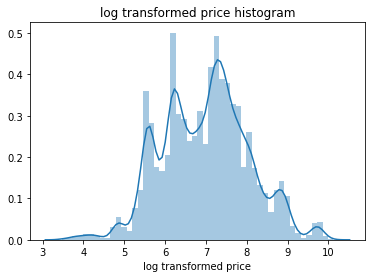

<Figure size 432x288 with 0 Axes>

In [17]:
from util.visualize import draw_hist
from util.s3_manager.manage import S3Manager
import numpy as np

draw_hist(np.log1p(clean_p["price"].rename("log transformed price")))
S3Manager("production-bobsim").save_plt_to_png(key="food_material_price_predict_model/image/log_price_hist.png")

In [18]:
price = clean_p["price"]
stdized_price = process_p["price"].rename("stdized_price")
log_transformed_price = np.log1p(clean_p["price"].rename("log_transformed_price"))

In [19]:
import pandas as pd
from scipy.stats import skew

price_df = pd.concat([price, stdized_price, log_transformed_price], axis=1)
print(price_df.columns)
pd.Series(skew(price_df), index=price_df.columns).rename("skew").to_frame().T

Index(['price', 'stdized_price', 'log_transformed_price'], dtype='object')


,price,stdized_price,log_transformed_price
skew,3.670128,3.670128,0.05643


## categorical

In [2]:
from util.geography import compose_geography
composed = compose_geography(clean_p["region"])
composed

0        강원도
1        강원도
2        강원도
3        강원도
4        강원도
        ... 
32818    충청도
32819    충청도
32820    충청도
32821    충청도
32822    충청도
Name: region, Length: 32823, dtype: object

In [20]:
(clean_p["region"].unique()).size

24

In [21]:
(clean_p["region"].value_counts()/clean_p["region"].value_counts().sum()*100).rename("%").to_frame().sort_values(by="%")

,%
강원,3.214210
강원춘천,3.287329
청주,3.460988
경기,3.622460
전주,3.716906
세종,3.790025
경북안동,3.838772
경기의정부,3.884471
전북전주,4.012430
경기수원,4.158669


In [22]:
import pandas as pd
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(440/clean_p["standard_item_name"].value_counts().sum())
df =(clean_p["standard_item_name"].value_counts()/clean_p["standard_item_name"].value_counts().sum()*100).rename("%").to_frame().sort_values(by="%")

0.013405234134600737


In [40]:
high_list=df.sort_values(by='%', ascending =False).head(49).index

In [41]:
high_list

Index(['배추', '포도', '고추', '고등어류', '열무', '아몬드', '건제품', '찹쌀', '조미제품', '양파', '감자', '팽이버섯', '벼', '건가공(해조)류', '젓갈(액젓)류', '천연조미료류', '고구마', '땅콩', '대파', '우유', '당근', '파프리카', '오이', '팥', '돈육', '상추', '호박', '양배추', '한우', '무', '깻잎', '메론', '생강', '피망(단고추)', '닭고기', '멸치류', '새송이', '토마토', '젓갈(일반)류', '수박', '콩', '건가공(포)류', '바나나', '호두', '조란', '조기류', '배', '레몬', '참외'], dtype='object')

In [39]:
high_list[0:10]

Index(['배추', '포도', '고추', '고등어류', '열무', '아몬드', '건제품', '찹쌀', '조미제품', '양파'], dtype='object')

In [43]:
filter_df = clean_p[~clean_p["standard_item_name"].isin(high_list)]

In [44]:
filter_df

,date,region,standard_item_name,price
7,2019-08-01,강원,블루베리,3510.000000
10,2019-08-01,강원,쇠고기,3000.000000
12,2019-08-01,강원,체리,1520.000000
19,2019-08-01,강원,사과,1980.000000
21,2019-08-01,강원,참다래(키위),544.000000
...,...,...,...,...
32807,2019-08-30,충북청주,김류,820.000000
32815,2019-08-30,충북청주,녹두,1500.000000
32816,2019-08-30,충북청주,참깨,1163.333333
32820,2019-08-30,충북청주,꽁치류,714.000000


In [50]:
filter_series = clean_p[~clean_p["standard_item_name"].isin(high_list)]['standard_item_name']

In [52]:
drop_dup = filter_series.drop_duplicates()

In [54]:
drop_list = drop_dup.to_list()

In [57]:
replace_df = drop_dup.replace(drop_list,'그외')

In [58]:
replace_df

7      그외
10     그외
12     그외
19     그외
21     그외
42     그외
52     그외
57     그외
74     그외
84     그외
86     그외
91     그외
100    그외
102    그외
104    그외
105    그외
114    그외
115    그외
119    그외
120    그외
261    그외
656    그외
Name: standard_item_name, dtype: object

In [56]:
sim = clean_p["standard_item_name"].value_counts()
sparse_index = sim[sim < 440].index

filtered = clean_p["standard_item_name"].apply(lambda x: "그외" if x in sparse_index else x)
filtered

0            감자
1           건제품
2            고추
3            깻잎
4            돈육
          ...  
32818         팥
32819    천연조미료류
32820        그외
32821        그외
32822        고추
Name: standard_item_name, Length: 32823, dtype: object

In [60]:
(filtered.value_counts()/filtered.value_counts().sum()*100).rename("%").to_frame().sort_values(by="%")

,%
레몬,1.343570
배,1.358803
조기류,1.358803
조란,1.389270
호두,1.398410
...,...
고등어류,1.852360
고추,2.553088
포도,3.025318
배추,3.055784


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50896 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47497 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52632 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib

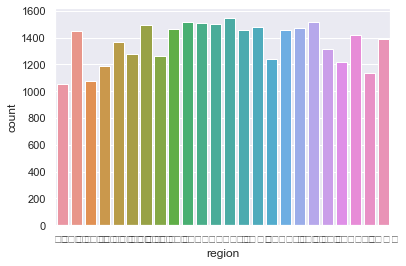

In [11]:
from util.visualize import draw_hist

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='darkgrid')

sns.countplot(x = 'region',
              data = clean_p)
plt.show()

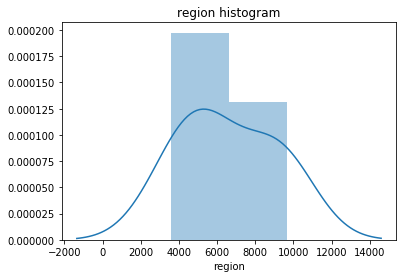

In [12]:
draw_hist(composed.value_counts())

# Compare: numeric value( nomal vs log1p ) // Base skew_values

In [66]:
orgin_df=pd.read_csv('https://production-bobsim.s3.ap-northeast-2.amazonaws.com/public_data/public_price/origin/csv/201908.csv', encoding='euc-kr')

In [67]:
columns = [
            "조사일자", "조사구분명",
            "표준품목명", "조사가격품목명", "표준품종명", "조사가격품종명",
            "조사등급명", "조사단위명", "당일조사가격", "조사지역명"
        ]

In [68]:
filtered_df=orgin_df[columns]

## Check numeric type

In [69]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97414 entries, 0 to 97413
Data columns (total 10 columns):
조사일자       97414 non-null object
조사구분명      97414 non-null object
표준품목명      97414 non-null object
조사가격품목명    97414 non-null object
표준품종명      97414 non-null object
조사가격품종명    97414 non-null object
조사등급명      97414 non-null object
조사단위명      97414 non-null object
당일조사가격     97414 non-null int64
조사지역명      97414 non-null object
dtypes: int64(1), object(9)
memory usage: 7.4+ MB


### hist using displot

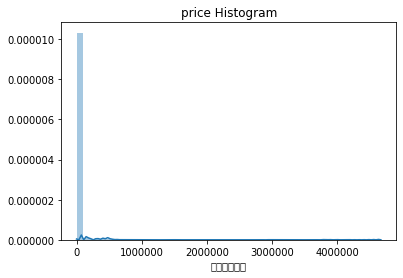

In [70]:
# see distribution of numecric type 
plt.title('price Histogram')
sns.distplot(data_df['당일조사가격'])


In [71]:
# check skew 
from scipy.stats import skew
features_index = filtered_df.dtypes[filtered_df.dtypes != 'object'].index

# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = filtered_df[features_index].apply(lambda x : skew(x))

# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

당일조사가격    13.296264
dtype: float64


## 로그변환

In [72]:
filtered_df[skew_features_top.index] = np.log1p(filtered_df[skew_features_top.index])

C:\Users\park\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## 분포도 확인 ( 결정한 이유 )

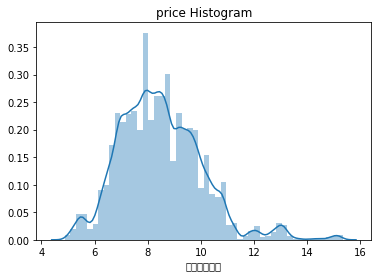

In [73]:
# see distribution of numecric type 
plt.title('price Histogram')
sns.distplot(filtered_df['당일조사가격'])

In [74]:
skew(filtered_df['당일조사가격'])

0.7655006976533527

### datetime 타입에서 년, 월, 일, 시간 추출


In [75]:
filtered_df['조사일자'] = filtered_df.조사일자.apply(pd.to_datetime)

C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
filtered_df['year']= filtered_df.조사일자.apply(lambda x : x.year)
filtered_df['month']=filtered_df.조사일자.apply(lambda x : x.month)
filtered_df['day']=filtered_df.조사일자.apply(lambda x: x.day)

C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [77]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97414 entries, 0 to 97413
Data columns (total 13 columns):
조사일자       97414 non-null datetime64[ns]
조사구분명      97414 non-null object
표준품목명      97414 non-null object
조사가격품목명    97414 non-null object
표준품종명      97414 non-null object
조사가격품종명    97414 non-null object
조사등급명      97414 non-null object
조사단위명      97414 non-null object
당일조사가격     97414 non-null float64
조사지역명      97414 non-null object
year       97414 non-null int64
month      97414 non-null int64
day        97414 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(8)
memory usage: 9.7+ MB


In [78]:
temp1=pd.read_csv('https://production-bobsim.s3.ap-northeast-2.amazonaws.com/public_data/public_price/origin/csv/201908.csv', encoding='euc-kr')
columns = [
            "조사일자", "조사구분명",
            "표준품목명", "조사가격품목명", "표준품종명", "조사가격품종명",
            "조사등급명", "조사단위명", "당일조사가격", "조사지역명"
        ]

In [103]:
def unit_fit(unit_name):
    unit=0
    if unit_name=='20KG' : unit= 200
    elif unit_name=='1.2KG' : unit= 12
    elif unit_name=='8KG' : unit= 80
    elif unit_name=='1KG' : unit=10
    elif unit_name=='1KG(단)' : unit=10
    elif unit_name=='1KG(1단)': unit=10
    elif unit_name=='10개': unit=10
    elif unit_name=='10마리': unit=10
    elif unit_name=='1L' : unit=10 
    elif unit_name=='100G': unit= 1
    elif unit_name=='1개' : unit= 1
    elif unit_name=='1마리' : unit= 1
    elif unit_name=='1속' : unit= 1
    elif unit_name=='1포기' : unit= 1
    elif unit_name=='200G' :unit=2
    elif unit_name=='2마리' : unit= 2
    elif unit_name=='500G' : unit= 5
    else: unit = 6
    
    return unit

In [105]:
temp2=temp1[temp1['조사구분명']=='소비자가격']
temp2 =temp2[['조사일자', '조사가격품목명','표준품종명','조사가격품종명','표준품목명','조사지역명','조사단위명','당일조사가격']]


In [106]:
temp2['price_unit']= temp2['조사단위명'].apply(lambda x : unit_fit(x))
temp2['averge_price']= temp2['당일조사가격']/temp2['price_unit']

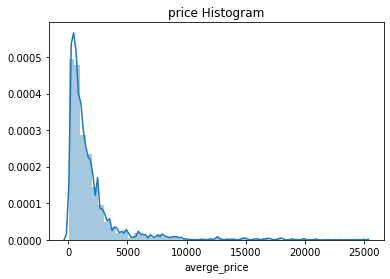

In [107]:
# see distribution of numecric type 
plt.title('price Histogram')
sns.distplot(temp2['averge_price'])

In [108]:
skew(temp2['averge_price']) # 소비자가격 skew

3.8459733534846507

In [84]:
skew(temp1['당일조사가격']) # 모든가격 skew

13.296264438735514

In [85]:
temp2['averge_price'] = np.log1p(temp2['averge_price'])
print('로그변화 후 skew 값')
skew(temp2['averge_price'])

로그변화 후 skew 값


0.12372746170184191

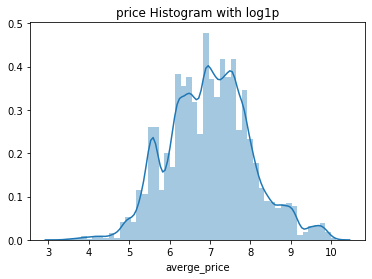

In [86]:
plt.title('price Histogram with log1p')
sns.distplot(temp2['averge_price'])